# Autoencoders for Pre-Training
### MNIST Data

## Loading MNIST Data

In [2]:
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np

train = pd.read_csv('../data/mnist/train.csv')
y_train = train.iloc[:,0]
train = train.iloc[:,1:]

train, validation, y_train, y_validation = train_test_split(train, y_train, test_size = .2)

y_train_mat = pd.get_dummies(np.array(y_train)).as_matrix()

In [4]:
from sklearn.preprocessing import Normalizer

normalize = Normalizer()
train = normalize.fit_transform(train)
validation = normalize.fit_transform(validation)

C:\Users\Neehar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Neehar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


## Building a Deep Softmax Classifier
##### In this section, we build a Deep NN Classifier which can also take specified(Pre-Initialized) weights as inputs

In [3]:
import tensorflow as tf
import numpy as np


class Deep_Classifier:
    
    def __init__(self, dims=None, activations=None, lr = 0.001, loss='rmse', epoch = 25, batch_size = 20, print_step = 500, initial_weights = None, initial_biases = None):
        self.dims = dims
        self.activations = activations
        self.lr = lr
        self.loss = loss
        self.epoch = epoch
        self.batch_size = batch_size
        self.weights = []
        self.biases = []
        self.print_step = print_step
        self.depth = len(dims)
        if initial_weights==None:
            self.initial_weights = []
        else:
            if type(initial_weights) is np.ndarray:
                self.initial_weights = [initial_weights]
            else:
                self.initial_weights = initial_weights
        if initial_biases==None:
            self.initial_biases = []
        else:
            if type(initial_biases) is np.ndarray:
                self.initial_biases = [initial_biases]
            else:
                self.initial_biases = initial_biases
    
    def fit(self, data, labels):
            return self.run_fit(data, labels, self.dims, self.activations, self.lr, self.loss, self.epoch, self.batch_size, self.print_step)
    
    
    def run_fit(self, data, labels, dims, activations, lr, loss, epoch , batch_size, print_step):
        n_rows = data.shape[0]
        tf.reset_default_graph()
        sess = tf.Session()
        
        # tensorflow graph input
        X = tf.placeholder(tf.float32, shape = [None, data.shape[1]], name = 'X')
        y = tf.placeholder(tf.float32, shape = [None, labels.shape[1]], name = 'y')
        learning_rate = tf.placeholder(tf.float32, shape=[])

        next_layer_input = X
        
        weights = []
        biases = []
        activations = activations + ['softmax']
        current_dim = data.shape[1]
        output_dim = labels.shape[1]
        
        # flag for pre-train weights
        pre_train_flag = True
        
        # append Auto-Encoder Pre-Trained weights
        for idx in range(len(self.initial_weights)):
            print('Initializing with Pre-Trained Weights for Layer {}'.format(idx + 1))
            weights.append(tf.Variable(self.initial_weights[idx], dtype=tf.float32))
            try:
                biases.append(tf.Variable(self.initial_biases[idx], dtype=tf.float32))
            except:
                print('Corresponding biases not provided, initializing random biases...')
                biases.append(tf.Variable(tf.truncated_normal([self.initial_weights[idx].shape[1]], dtype=tf.float32)))
            current_dim = self.initial_weights[idx].shape[1]
        
        # append rest of the weights, the un-pretrained weights
        for idx in range(len(self.initial_weights), len(dims)):
            weights.append(tf.Variable(tf.truncated_normal([current_dim, dims[idx]], dtype=tf.float32)))
            biases.append(tf.Variable(tf.truncated_normal([dims[idx]], dtype=tf.float32)))
            current_dim = dims[idx]
        
        # append the weight for the final layer, softmax/sigmoid
        #weights.append(tf.Variable(tf.truncated_normal([current_dim, output_dim], dtype=tf.float32)))
        #biases.append(tf.Variable(tf.truncated_normal([output_dim], dtype=tf.float32)))
        weights.append(tf.Variable(tf.zeros([current_dim, output_dim], dtype=tf.float32)))
        biases.append(tf.Variable(tf.zeros([output_dim], dtype=tf.float32)))
        
        dims=dims+[output_dim]
        
        output = X
        for index in range(len(dims)):
            output = self.activate(tf.matmul(output, weights[index]) + biases[index], activations[index])
        
        prediction = output
        
        if loss == 'rmse':
            cost = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y, prediction))))
        elif loss == 'cross-entropy':
            #cost = -tf.reduce_mean(y * tf.log(prediction))
            cost=-tf.reduce_sum(y*tf.log(tf.clip_by_value(prediction,1e-10,1.0)))
        train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

        init = tf.global_variables_initializer()
        sess.run(init)
        
        lr_adapt_flag = True

        for i in range(epoch):
            if i > epoch*3/4 and lr_adapt_flag:
                print('lr prev',lr)
                lr=lr/3.
                lr_adapt_flag=False
                print('lr new',lr)    

            batch_idx = np.random.randint(data.shape[0], size = batch_size)
            batch = data[batch_idx,:]
            batch_labels = np.array(labels)[batch_idx]
            sess.run(train_step, feed_dict = {X:np.array(batch), y:np.array(batch_labels), learning_rate:lr})
            if i % print_step == 0:
                print (i, " cost", sess.run(cost, feed_dict={X:np.array(batch), y:np.array(batch_labels)}))
        
        for w, b in zip(weights, biases):
            self.weights.append(w.eval(session=sess))
            self.biases.append(b.eval(session=sess))
    
    def transform(self, data):
        tf.reset_default_graph()
        sess = tf.Session()
        X = tf.constant(data, dtype=tf.float32)
        for w, b, a in zip(self.weights, self.biases, self.activations+['softmax']):
            weight = tf.constant(w, dtype=tf.float32)
            bias = tf.constant(b, dtype=tf.float32)
            score = tf.matmul(X, weight) + b
            X = self.activate(score, a)
        y_hat = tf.argmax(X, 1)
        return y_hat.eval(session=sess)
    
        #return sess.run(prediction, feed_dict={})
    def activate(self, linear, name):
        if name == 'sigmoid':
            return tf.nn.sigmoid(linear, name='encoded')
        elif name == 'softmax':
            return tf.nn.softmax(linear, name='encoded')
        elif name == 'linear':
            return linear
        elif name == 'tanh':
            return tf.nn.tanh(linear, name='encoded')
        elif name == 'relu':
            return tf.nn.relu(linear, name='encoded')

In [15]:
mnist_dc = Deep_Classifier(dims=[1000], activations=['sigmoid'], lr = 0.007, loss='cross-entropy', epoch = 20000, batch_size = 20, print_step = 100)

In [16]:
mnist_dc.fit(data = train, labels = y_train_mat)

0  cost 56.8709
100  cost 8.89484
200  cost 2.78163
300  cost 3.54794
400  cost 3.65948
500  cost 5.3454
600  cost 4.52244
700  cost 2.58424
800  cost 1.36574
900  cost 4.33336
1000  cost 1.88074
1100  cost 1.21151
1200  cost 1.32175
1300  cost 1.78417
1400  cost 3.06627
1500  cost 6.69451
1600  cost 2.93861
1700  cost 1.43711
1800  cost 0.271408
1900  cost 10.6957
2000  cost 1.0787
2100  cost 0.602933
2200  cost 0.985242
2300  cost 2.80263
2400  cost 0.242571
2500  cost 0.808145
2600  cost 0.566859
2700  cost 3.6223
2800  cost 1.54691
2900  cost 0.192297
3000  cost 0.678115
3100  cost 0.39053
3200  cost 1.41521
3300  cost 0.620593
3400  cost 0.219807
3500  cost 0.895233
3600  cost 1.3626
3700  cost 0.626854
3800  cost 1.27687
3900  cost 0.115319
4000  cost 0.992088
4100  cost 0.0967592
4200  cost 0.490633
4300  cost 0.358019
4400  cost 0.379026
4500  cost 1.28053
4600  cost 0.644643
4700  cost 1.34218
4800  cost 0.24086
4900  cost 0.0762628
5000  cost 0.109844
5100  cost 1.31886
5200 

In [17]:
y_train_hat = mnist_dc.transform(train)
y_validation_hat = mnist_dc.transform(validation)

In [18]:
print((y_train_hat==y_train).sum()/float(y_train.shape[0]))
print((y_validation_hat==y_validation).sum()/float(y_validation.shape[0]))

0.999821428571
0.98


## Greedy Layer-Wise Training; Stacked Denoising Autoencoder

In [7]:
import numpy as np


def get_batch(X, X_, size):
    a = np.random.choice(len(X), size, replace=False)
    return X[a], X_[a]


def noise_validator(noise, allowed_noises):
    '''Validates the noise provided'''
    try:
        if noise in allowed_noises:
            return True
        elif noise.split('-')[0] == 'mask' and float(noise.split('-')[1]):
            t = float(noise.split('-')[1])
            if t >= 0.0 and t <= 1.0:
                return True
            else:
                return False
    except:
        return False
    pass


allowed_activations = ['sigmoid', 'tanh', 'softmax', 'relu', 'linear']
allowed_noises = [None, 'gaussian', 'mask']
allowed_losses = ['rmse', 'cross-entropy']


class StackedAutoEncoder:
    """A deep autoencoder with denoising capability"""

    def assertions(self):
        global allowed_activations, allowed_noises, allowed_losses
        assert self.loss in allowed_losses, 'Incorrect loss given'
        assert 'list' in str(
            type(self.dims)), 'dims must be a list even if there is one layer.'
        assert len(self.epoch) == len(
            self.dims), "No. of epochs must equal to no. of hidden layers"
        assert len(self.activations) == len(
            self.dims), "No. of activations must equal to no. of hidden layers"
        assert all(
            True if x > 0 else False
            for x in self.epoch), "No. of epoch must be atleast 1"
        assert set(self.activations + allowed_activations) == set(
            allowed_activations), "Incorrect activation given."
        assert noise_validator(
            self.noise, allowed_noises), "Incorrect noise given"

    def __init__(self, dims, activations, epoch=1000, noise=None, loss='rmse',
                 lr=0.001, batch_size=100, print_step=50):
        self.print_step = print_step
        self.batch_size = batch_size
        self.lr = lr
        self.loss = loss
        self.activations = activations
        self.noise = noise
        self.epoch = epoch
        self.dims = dims
        self.assertions()
        self.depth = len(dims)
        self.weights, self.biases = [], []

    def add_noise(self, x):
        if self.noise == 'gaussian':
            n = np.random.normal(0, 0.1, (len(x), len(x[0])))
            return x + n
        if 'mask' in self.noise:
            frac = float(self.noise.split('-')[1])
            temp = np.copy(x)
            for i in temp:
                n = np.random.choice(len(i), round(
                    frac * len(i)), replace=False)
                i[n] = 0.5
            return temp
        if self.noise == 'sp':
            pass

    def fit(self, x):
        for i in range(self.depth):
            print('Layer {0}'.format(i + 1))
            if self.noise is None:
                x = self.run(data_x=x, activation=self.activations[i],
                             data_x_=x,
                             hidden_dim=self.dims[i], epoch=self.epoch[
                                 i], loss=self.loss,
                             batch_size=self.batch_size, lr=self.lr,
                             print_step=self.print_step)
            else:
                temp = np.copy(x)
                x = self.run(data_x=self.add_noise(temp),
                             activation=self.activations[i], data_x_=x,
                             hidden_dim=self.dims[i],
                             epoch=self.epoch[
                                 i], loss=self.loss,
                             batch_size=self.batch_size,
                             lr=self.lr, print_step=self.print_step)

    def transform(self, data):
        tf.reset_default_graph()
        sess = tf.Session()
        x = tf.constant(data, dtype=tf.float32)
        for w, b, a in zip(self.weights, self.biases, self.activations):
            weight = tf.constant(w, dtype=tf.float32)
            bias = tf.constant(b, dtype=tf.float32)
            layer = tf.matmul(x, weight) + bias
            x = self.activate(layer, a)
        return x.eval(session=sess)

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def run(self, data_x, data_x_, hidden_dim, activation, loss, lr,
            print_step, epoch, batch_size=100):
        tf.reset_default_graph()
        input_dim = len(data_x[0])
        sess = tf.Session()
        x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='x')
        x_ = tf.placeholder(dtype=tf.float32, shape=[
                            None, input_dim], name='x_')
        encode = {'weights': tf.Variable(tf.truncated_normal(
            [input_dim, hidden_dim], dtype=tf.float32)),
            'biases': tf.Variable(tf.truncated_normal([hidden_dim],
                                                      dtype=tf.float32))}
        decode = {'biases': tf.Variable(tf.truncated_normal([input_dim],
                                                            dtype=tf.float32)),
                  'weights': tf.transpose(encode['weights'])}
        encoded = self.activate(
            tf.matmul(x, encode['weights']) + encode['biases'], activation)
        decoded = tf.matmul(encoded, decode['weights']) + decode['biases']

        # reconstruction loss
        if loss == 'rmse':
            loss = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(x_, decoded))))
        elif loss == 'cross-entropy':
            #loss = -tf.reduce_mean(x_ * tf.log(decoded))
            loss = -tf.reduce_sum(x_ * tf.log(tf.clip_by_value(decoded,1e-10,1.0)))
        train_op = tf.train.GradientDescentOptimizer(lr).minimize(loss)

        sess.run(tf.global_variables_initializer())
        for i in range(epoch):
            b_x, b_x_ = get_batch(
                data_x, data_x_, batch_size)
            sess.run(train_op, feed_dict={x: b_x, x_: b_x_})
            if i % print_step == 0:
                l = sess.run(loss, feed_dict={x: data_x, x_: data_x_})
                print('epoch {0}: global loss = {1}'.format(i, l))
        # debug
        # print('Decoded', sess.run(decoded, feed_dict={x: self.data_x_})[0])
        
        self.weights.append(sess.run(encode['weights']))
        self.biases.append(sess.run(encode['biases']))
        return sess.run(encoded, feed_dict={x: data_x_})

    def activate(self, linear, name):
        if name == 'sigmoid':
            return tf.nn.sigmoid(linear, name='encoded')
        elif name == 'softmax':
            return tf.nn.softmax(linear, name='encoded')
        elif name == 'linear':
            return linear
        elif name == 'tanh':
            return tf.nn.tanh(linear, name='encoded')
        elif name == 'relu':
            return tf.nn.relu(linear, name='encoded')

#####  Greedy Training the 1st layer using SDA

In [25]:
mnist_sda = StackedAutoEncoder(dims=[1000], activations=['sigmoid' ],noise='mask-.1', epoch=[20000], loss='rmse', lr=0.051, batch_size=100, print_step=2000)

train_pt = mnist_sda.fit_transform(train)
validation_pt = mnist_sda.transform(validation)

Layer 1
epoch 0: global loss = 21.400068283081055
epoch 2000: global loss = 14.170794486999512
epoch 4000: global loss = 13.375250816345215
epoch 6000: global loss = 12.56951904296875
epoch 8000: global loss = 11.712116241455078
epoch 10000: global loss = 10.844687461853027
epoch 12000: global loss = 10.00213623046875
epoch 14000: global loss = 9.207575798034668
epoch 16000: global loss = 8.473504066467285
epoch 18000: global loss = 7.805402755737305


In [8]:
mnist_sda = StackedAutoEncoder(dims=[1000], activations=['sigmoid' ],noise='mask-.1', epoch=[5000], loss='rmse', lr=0.051, batch_size=100, print_step=2000)

train_pt = mnist_sda.fit_transform(train)
validation_pt = mnist_sda.transform(validation)

Layer 1
epoch 0: global loss = 20.770864486694336
epoch 2000: global loss = 14.104645729064941
epoch 4000: global loss = 13.332223892211914


In [9]:
pre_train_weights = mnist_sda.weights
pre_train_biases = mnist_sda.biases

In [45]:
y_train_hat_pt = mnist_dc_PT.transform(train)
y_validation_hat_pt = mnist_dc_PT.transform(validation)
print((y_train_hat_pt ==y_train).sum()/float(y_train.shape[0]))
print((y_validation_hat_pt ==y_validation).sum()/float(y_validation.shape[0]))

1.0
0.980833333333


### Deep Classifier and SDA functions have been implemented, now to evaluate Supervised Deep Classification Networrk without Unsupervised Pre-Training Vs Supervised DNN Classification with Unsupervised Pre-Training

In [29]:
def Classify_Without_PT(train, validation):
    mnist_dc = Deep_Classifier(dims=[1000], activations=['sigmoid'], lr = 0.007, loss='cross-entropy', epoch = 20000, batch_size = 20, print_step = 2000)
    mnist_dc.fit(data = train, labels = y_train_mat)
    y_train_hat = mnist_dc.transform(train)
    y_validation_hat = mnist_dc.transform(validation)
    return np.mean(y_train_hat==y_train), np.mean(y_validation_hat==y_validation)


In [30]:
def Classify_With_PT(train, validation):
    mnist_sda = StackedAutoEncoder(dims=[1000], activations=['sigmoid' ],noise='mask-.1', epoch=[20000], loss='rmse', lr=0.051, batch_size=100, print_step=2000)
    #.03, cross ent
    train_pt = mnist_sda.fit_transform(train)
    validation_pt = mnist_sda.transform(validation)
    pre_train_weights = mnist_sda.weights
    mnist_dc_PT = Deep_Classifier(dims=[1000], activations=['sigmoid'], lr = 0.007, loss='cross-entropy', epoch = 20000, batch_size = 100, print_step = 2000, initial_weights=pre_train_weights)
    #
    mnist_dc_PT.fit(data = train,labels = y_train_mat)
    y_train_hat_pt = mnist_dc_PT.transform(train)
    y_validation_hat_pt = mnist_dc_PT.transform(validation)
    return np.mean(y_train_hat_pt==y_train), np.mean(y_validation_hat_pt==y_validation)


In [31]:
no_pt_train_error=[]
no_pt_validation_error=[]
with_pt_train_error=[]
with_pt_validation_error=[]

In [32]:
for itr in range(20):
    no_pt_train_err, no_pt_validation_err = Classify_Without_PT(train, validation)
    print ('Without Pre-Training',no_pt_train_err, no_pt_validation_err)
    print ('===============================================================')
    with_pt_train_err, with_pt_validation_err = Classify_With_PT(train, validation)
    print ('With Pre-Training',with_pt_train_err, with_pt_validation_err)
    print ('===============================================================')
    
    no_pt_train_error.append(no_pt_train_err)
    no_pt_validation_error.append(no_pt_validation_err)
    with_pt_train_error.append(with_pt_train_err)
    with_pt_validation_error.append(with_pt_validation_err)

0  cost 64.0863
2000  cost 2.57665
4000  cost 0.395366
6000  cost 0.349975
8000  cost 0.149719
10000  cost 0.213889
12000  cost 0.000177034
14000  cost 0.126917
lr prev 0.007
lr new 0.0023333333333333335
16000  cost 0.0170205
18000  cost 0.00113733
Without Pre-Training 0.999583333333 0.979642857143
Layer 1
epoch 0: global loss = 21.378141403198242
epoch 2000: global loss = 14.068449020385742
epoch 4000: global loss = 13.240703582763672
epoch 6000: global loss = 12.394339561462402
epoch 8000: global loss = 11.500768661499023
epoch 10000: global loss = 10.609177589416504
epoch 12000: global loss = 9.757501602172852
epoch 14000: global loss = 8.966238021850586
epoch 16000: global loss = 8.242695808410645
epoch 18000: global loss = 7.586456775665283
Initializing with Pre-Trained Weights for Layer 1
Corresponding biases not provided, initializing random biases...
0  cost 252.259
2000  cost 2.36386
4000  cost 0.708993
6000  cost 0.172644
8000  cost 0.60797
10000  cost 0.0315266
12000  cost 0

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Visualizing Training Accuracy

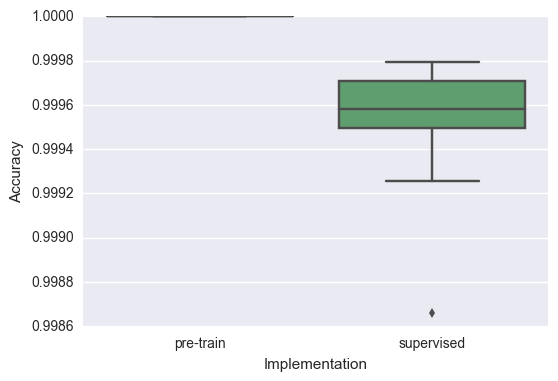

In [37]:
error_df = pd.DataFrame({'Implementation' : ['pre-train']*len(with_pt_train_error)+['supervised']*len(with_pt_train_error), \
                        'Accuracy':with_pt_train_error+no_pt_train_error})


sns.boxplot(x='Implementation',y='Accuracy', data=error_df)


### Visualizing Validation Accuracy

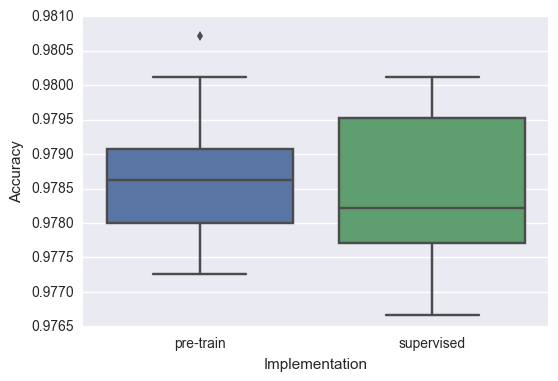

In [36]:
error_df = pd.DataFrame({'Implementation' : ['pre-train']*len(with_pt_validation_error)+['supervised']*len(with_pt_validation_error), \
                        'Accuracy':with_pt_validation_error+no_pt_validation_error})


sns.boxplot(x='Implementation',y='Accuracy', data=error_df)


##### From the plots we can observe that the Autoencoder Pre-trained network outs 100% training accuracy in each of the 20 runs. On, the other hand, the Supervised classifier outputs slightly lower accuracy, ie. a few decimals below 100%. 
##### The accuracy on the validation set for pre-trained model implies higher confidence with a very slightly higher accuracy as compared to the supervised model. We also can see that the accuracy in one of the training examples of the supervised model is very low which can be result of poor in initializations of the weights. This can be  clearly avoided using Pre-Training

##### An important concept that we learn here is that though the Validation Accuracy by Unsupervised PreTraining can be lower compared to without pretraining, Autoencoders do satisfy the important job of initializing weights near to Optimal values, which in rather complex problems and deeper networks can be very beneficial as said in the literature. 